<a href="https://colab.research.google.com/github/soumyata08/artemis/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upgrade Pillow to a version that includes is_directory (9.1.0 or later)
!pip uninstall -y Pillow
!pip install Pillow>=10.4.0

# Reinstall dependencies to ensure compatibility
!pip install facenet-pytorch numpy torch torchvision kagglehub

Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.2.1 which is incompatible.
  Using cached pillow-10.2.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached pillow-10.2.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1


In [ ]:
!pip install facenet-pytorch numpy Pillow torch torchvision kagglehub --quiet

In [ ]:
import kagglehub
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
from PIL import Image
from google.colab import files
import os
from IPython.display import display

In [ ]:
path = kagglehub.dataset_download("rawatjitesh/avengers-face-recognition")
print("Path to dataset files:", path)

100%|██████████| 54.5M/54.5M [00:00<00:00, 201MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rawatjitesh/avengers-face-recognition/versions/1


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=False, device=device, min_face_size=15, thresholds=[0.5, 0.6, 0.6])
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
def load_and_encode(image_path, name):
    try:
        img = Image.open(image_path).convert('RGB')
        print(f"Processing {image_path}: Size {img.size}")
        img = img.resize((160, 160))
        faces = mtcnn.detect(img)
        if faces is None or len(faces) == 0:
            print(f"No face detected in {name}")
            return None, None
        if len(faces) > 1:
            print(f"Multiple faces in {name}. Using first face.")
        img_cropped = mtcnn(img)
        if img_cropped is None:
            print(f"Failed to crop face in {name}")
            return None, None
        img_cropped = img_cropped.unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = resnet(img_cropped).cpu().numpy()
        return embedding[0], name
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

In [ ]:
def recognize_face(test_path, known_encodings, known_names, threshold=1.0):
    try:
        img = Image.open(test_path).convert('RGB')
        img = img.resize((160, 160))
        faces = mtcnn.detect(img)
        if faces is None or len(faces) == 0:
            print(f"No face detected in test image")
            return
        img_cropped = mtcnn(img)
        if img_cropped is None:
            print("Failed to crop face in test image.")
            return
        img_cropped = img_cropped.unsqueeze(0).to(device)
        with torch.no_grad():
            test_embedding = resnet(img_cropped).cpu().numpy()[0]

        distances = np.array([np.linalg.norm(known_encodings[i] - test_embedding)
                            for i in range(len(known_encodings))])
        best_idx = np.argmin(distances)

        if distances[best_idx] < threshold:
            print(f"Match found: {known_names[best_idx]} (Distance: {distances[best_idx]:.4f})")
        else:
            print(f"Unknown person. Closest: {known_names[best_idx]} (Distance: {distances[best_idx]:.4f})")

        display(img)
    except Exception as e:
        print(f"Error processing test image: {e}")

In [ ]:
known_encodings, known_names = [], []
cropped_dir = os.path.join(path, 'cropped_images')
if not os.path.isdir(cropped_dir):
    print(f"Directory {cropped_dir} not found. Exiting.")
    exit()

In [ ]:
celebrity_image_totals = {}
for root, _, filenames in os.walk(cropped_dir):
    celebrity = os.path.basename(root) if root != cropped_dir else 'unknown'
    if celebrity == 'unknown':
        continue
    image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        celebrity_image_totals[celebrity] = len(image_files)

In [ ]:
celebrity_counts = {}
for root, _, filenames in os.walk(cropped_dir):
    celebrity = os.path.basename(root) if root != cropped_dir else 'unknown'
    if celebrity == 'unknown':
        continue
    if celebrity not in celebrity_counts:
        celebrity_counts[celebrity] = 0
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, filename)
            encoding, name = load_and_encode(image_path, f"{celebrity}/{filename}")
            if encoding is not None:
                known_encodings.append(encoding)
                known_names.append(celebrity)
                celebrity_counts[celebrity] += 1
                total_for_celeb = celebrity_image_totals.get(celebrity, 0)
                if celebrity_counts[celebrity] % 5 ==0:
                  print(f"Encoded: {celebrity}/{filename} ({celebrity_counts[celebrity]}/{total_for_celeb})")
            if len(known_encodings) % 50 == 0:
                torch.cuda.empty_cache()

Processing /root/.cache/kagglehub/datasets/rawatjitesh/avengers-face-recognition/versions/1/cropped_images/robert_downey_jr/robert_downey_jr2.png: Size (103, 103)
Multiple faces in robert_downey_jr/robert_downey_jr2.png. Using first face.
Processing /root/.cache/kagglehub/datasets/rawatjitesh/avengers-face-recognition/versions/1/cropped_images/robert_downey_jr/robert_downey_jr24.png: Size (86, 86)
Multiple faces in robert_downey_jr/robert_downey_jr24.png. Using first face.
Processing /root/.cache/kagglehub/datasets/rawatjitesh/avengers-face-recognition/versions/1/cropped_images/robert_downey_jr/robert_downey_jr19.png: Size (333, 333)
Multiple faces in robert_downey_jr/robert_downey_jr19.png. Using first face.
Processing /root/.cache/kagglehub/datasets/rawatjitesh/avengers-face-recognition/versions/1/cropped_images/robert_downey_jr/robert_downey_jr32.png: Size (80, 80)
Multiple faces in robert_downey_jr/robert_downey_jr32.png. Using first face.
Processing /root/.cache/kagglehub/datasets

In [ ]:
print("\nSummary of encoded images per celebrity:")
for celebrity, count in celebrity_counts.items():
    print(f"{celebrity}: {count} images encoded")


Summary of encoded images per celebrity:
robert_downey_jr: 51 images encoded
chris_hemsworth: 53 images encoded
chris_evans: 49 images encoded
scarlett_johansson: 54 images encoded
mark_ruffalo: 66 images encoded


In [ ]:
if known_encodings:
    np.save("celebrity_encodings.npy", np.array(known_encodings))
    np.save("celebrity_names.npy", np.array(known_names))
    print("Training complete.")
else:
    print("No valid encodings generated. Proceeding to testing anyway.")


Training complete.


In [ ]:
torch.cuda.empty_cache()


Upload a test image:


Saving img8.webp to img8 (2).webp
Match found: chris_hemsworth (Distance: 0.6821)


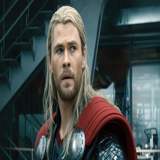

In [ ]:
print("\nUpload a test image:")
uploaded_test = files.upload()
if uploaded_test:
    test_path = f"test_{next(iter(uploaded_test))}"
    with open(test_path, "wb") as f:
        f.write(uploaded_test[next(iter(uploaded_test))])
    if known_encodings.size > 0:
        known_encodings = np.load("celebrity_encodings.npy", allow_pickle=True)
        known_names = np.load("celebrity_names.npy", allow_pickle=True)
        recognize_face(test_path, known_encodings, known_names)
    else:
        print("No encodings available for comparison.")
else:
    print("No test image uploaded.")